In [1]:
import numpy as np
import matplotlib.pyplot as plt
from worldModels import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import scipy.optimize
import scipy.io
import os.path

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


# Speficy whether or not to save figures
save_figures = True

In [3]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [4]:
def make_switching_world(rlow, rhigh, nblocks, ntrialsLow, ntrialsHigh):
    ratesL = (np.mod(np.arange(nblocks), 2)) * (rhigh - rlow) + rlow
    ratesR = (1 - np.mod(np.arange(nblocks), 2)) * (rhigh - rlow) + rlow
    if np.random.rand() > 0.5:
        rates = np.vstack((ratesL, ratesR)).T
    else:
        rates = np.vstack((ratesR, ratesL)).T
    ntrials = np.random.uniform(low=ntrialsLow, high=ntrialsHigh, size=nblocks).astype('int')
    world = PersistentWorld(rates=rates, ntrials=ntrials)
    return world

def make_switching_world_withCheck(rlow, rhigh, nblocks, ntrialsLow, ntrialsHigh):
    ratesL = (np.mod(np.arange(nblocks), 2)) * (rhigh - rlow) + rlow
    ratesR = (1 - np.mod(np.arange(nblocks), 2)) * (rhigh - rlow) + rlow
    if np.random.rand() > 0.5:
        rates = np.vstack((ratesL, ratesR)).T
    else:
        rates = np.vstack((ratesR, ratesL)).T
    ntrials = np.random.uniform(low=ntrialsLow, high=ntrialsHigh, size=nblocks).astype('int')
    world = PersistentWorldWithCheck(rates=rates, ntrials=ntrials, threshold=0.8)
    return world

def errorsigmoid(p, x, y):
    '''
    Error function used for sigmoid fitting
    '''
    lapse = p[2]
    preds = lapse + (1 - 2 * lapse) * 1 / (1 + np.exp(-p[0] * (x + p[1])))
    
    return np.sum((preds - y)**2)

In [34]:
def find_LR_transition_fit(world, agent, window):
    '''
    For a switching world, determines the agent transition functions,
    for left->right and right->left transitions
    window: how many trials after the transition do we want to keep for fitting?
    '''
    # Find where the block transitions happen
    side_history = np.array(world.rate_history)[:,0]
    blocktrans = np.where(np.diff(side_history) != 0)[0][:-1]

    # Get the choices around the transition
    choicelst = []
    for i in range(window):
        choicelst.append(np.array(agent.choice_history)[blocktrans + i])

    choicelst = np.array(choicelst)

    #print('choicemean = ', np.mean(choicelst[:,::2]), 'side=  ', world.side_history[0][0])
    pRight, pLeft = fit_sigmoidal(choicelst, first_side=world.side_history[0][0])
    return (pRight, pLeft)
    
    
    
def find_transition_guess(sig):
    '''
    Returns the offset where a time series crosses 0.5
    '''
    return np.argmin((sig-0.5)**2) 

def find_transition_guess_binary(sig):
    '''
    Returns the offset where a time series crosses 0.5, through binary segmentation
    '''
    candidates = np.where(np.diff(sig > 0.5) != 0)[0]
    if len(candidates) == 0:
        return -1
    else:
        return np.where(np.diff(sig > 0.5) != 0)[0][0]


def fit_sigmoidal(choicelst, first_side):
    '''
    Fit a sigmoidal to the average choice data
    first_side: first side that is rewarded, i.e. world.side_history[0][0]
    '''
    #print('choicemean = ', np.mean(choicelst[:,::2]), 'side=  ', first_side)
    if first_side == 0:
        #print('left')
        leftAverage = np.mean(choicelst[:,::2], axis=1)
        rightAverage = np.mean(choicelst[:,1::2], axis=1)
    else:
        #print('right')
        rightAverage = np.mean(choicelst[:,::2], axis=1)
        leftAverage = np.mean(choicelst[:,1::2], axis=1)

    offsets = np.arange(len(leftAverage))

    # Fit right transitions
    funR = lambda x: errorsigmoid(x, offsets, rightAverage)
    switchGuessR = find_transition_guess_binary(rightAverage) #offset that crosses 0.5
    if switchGuessR == -1: # No switch happened!
        pRight = [0, -np.inf, 0]
    else:
        paramsRight = scipy.optimize.minimize(funR, [1,-switchGuessR,0])
        pRight = paramsRight.x
    
    funL = lambda x: errorsigmoid(x, offsets, leftAverage)
    switchGuessL = find_transition_guess_binary(leftAverage)
    if switchGuessL == -1: # No switch happened!
        pLeft = [0, -np.inf, 0]
    else: 
        paramsLeft = scipy.optimize.minimize(funL, [-1,-switchGuessL,0])
        pLeft = paramsLeft.x
    
    return pRight, pLeft

In [117]:
np.random.seed(0)
simtype = 'inf-based'
pswitchlst = np.linspace(0.01, 0.45, 25)
prewlst = np.linspace(0.55, 0.99, 20)

N_iters = 50
num_states = 2
obs_dim = 1
rlow = 0.2
rhigh = 0.8
nblocks = 100
eps = 0
ntrials_per_block = [150, 200]

T11lst = np.zeros((len(pswitchlst), len(prewlst)))
T22lst = np.zeros((len(pswitchlst), len(prewlst)))
E1lst = np.zeros((len(pswitchlst), len(prewlst)))
E2lst = np.zeros((len(pswitchlst), len(prewlst)))
efflist = np.zeros((len(pswitchlst), len(prewlst)))
PRslopelist = np.zeros((len(pswitchlst), len(prewlst)))
PLslopelist = np.zeros((len(pswitchlst), len(prewlst)))
PRoffsetlist = np.zeros((len(pswitchlst), len(prewlst)))
PLoffsetlist = np.zeros((len(pswitchlst), len(prewlst)))
LapseL = np.zeros((len(pswitchlst), len(prewlst)))
LapseR = np.zeros((len(pswitchlst), len(prewlst)))


for idsw, psw in enumerate(pswitchlst):
    print('* pswitch = ', psw)
    for idrew, prew in enumerate(prewlst):
        print('     prew = ', prew)
        world = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
        agent = EGreedyInferenceBasedAgent(prew=prew, pswitch=psw, eps=eps)
        exp = Experiment(agent, world)
        exp.run()  

        # Fit HMM to choice sequence
        data = np.array(agent.choice_history)[:,None] 

        ## testing the constrained transitions class
        hmm = ssm.HMM(num_states, obs_dim, observations="bernoulli")
        hmm_lls = hmm.fit(data, method="em", num_iters=N_iters, init_method="kmeans", verbose=0)

        # Sigmoidal fit for choice transitions
        pR, pL = find_LR_transition_fit(world, agent, window=15)

        efflist[idsw][idrew] = agent.find_efficiency()
        T11lst[idsw][idrew] = hmm.transitions.transition_matrix[0][0]
        T22lst[idsw][idrew] = hmm.transitions.transition_matrix[1][1]
        E1lst[idsw][idrew] = logistic(hmm.observations.logit_ps)[0]
        E2lst[idsw][idrew] = logistic(hmm.observations.logit_ps)[1]
        PRslopelist[idsw][idrew] = pR[0]
        PLslopelist[idsw][idrew] = pL[0]
        PRoffsetlist[idsw][idrew] = pR[1]
        PLoffsetlist[idsw][idrew] = pL[1]
        LapseL[idsw][idrew] = pL[2]
        LapseR[idsw][idrew] = pR[2]
        
        
    
                  

* pswitch =  0.01
     prew =  0.55
     prew =  0.5731578947368422
     prew =  0.5963157894736842
     prew =  0.6194736842105264
     prew =  0.6426315789473684
     prew =  0.6657894736842106
     prew =  0.6889473684210526
     prew =  0.7121052631578948
     prew =  0.7352631578947368
     prew =  0.758421052631579
     prew =  0.781578947368421
     prew =  0.8047368421052632
     prew =  0.8278947368421052
     prew =  0.8510526315789474
     prew =  0.8742105263157895
     prew =  0.8973684210526316
     prew =  0.9205263157894736
     prew =  0.9436842105263158
     prew =  0.966842105263158
     prew =  0.99
* pswitch =  0.028333333333333335
     prew =  0.55
     prew =  0.5731578947368422
     prew =  0.5963157894736842
     prew =  0.6194736842105264
     prew =  0.6426315789473684
     prew =  0.6657894736842106
     prew =  0.6889473684210526
     prew =  0.7121052631578948
     prew =  0.7352631578947368
     prew =  0.758421052631579
     prew =  0.781578947368421
   

     prew =  0.9436842105263158
     prew =  0.966842105263158
     prew =  0.99
* pswitch =  0.24833333333333335
     prew =  0.55
     prew =  0.5731578947368422
     prew =  0.5963157894736842
     prew =  0.6194736842105264
     prew =  0.6426315789473684
     prew =  0.6657894736842106
     prew =  0.6889473684210526
     prew =  0.7121052631578948
     prew =  0.7352631578947368
     prew =  0.758421052631579
     prew =  0.781578947368421
     prew =  0.8047368421052632
     prew =  0.8278947368421052
     prew =  0.8510526315789474
     prew =  0.8742105263157895
     prew =  0.8973684210526316
     prew =  0.9205263157894736
     prew =  0.9436842105263158
     prew =  0.966842105263158
     prew =  0.99
* pswitch =  0.26666666666666666
     prew =  0.55
     prew =  0.5731578947368422
     prew =  0.5963157894736842
     prew =  0.6194736842105264
     prew =  0.6426315789473684
     prew =  0.6657894736842106
     prew =  0.6889473684210526
     prew =  0.7121052631578948
  

In [116]:
# Q-learning agent
simtype = 'qlearning'
np.random.seed(0)
gammalst = np.linspace(0.01, 1.4, 30)
epslst = np.linspace(0.01, 0.5, 20)

N_iters = 50
num_states = 2
obs_dim = 1
rlow = 0
rhigh = 1
nblocks = 100
ntrials_per_block = [150, 200]

T11lst = np.zeros((len(gammalst), len(epslst)))
T22lst = np.zeros((len(gammalst), len(epslst)))
E1lst = np.zeros((len(gammalst), len(epslst)))
E2lst = np.zeros((len(gammalst), len(epslst)))
efflist = np.zeros((len(gammalst), len(epslst)))
PRslopelist = np.zeros((len(gammalst), len(epslst)))
PLslopelist = np.zeros((len(gammalst), len(epslst)))
PRoffsetlist = np.zeros((len(gammalst), len(epslst)))
PLoffsetlist = np.zeros((len(gammalst), len(epslst)))
LapseL = np.zeros((len(gammalst), len(epslst)))
LapseR = np.zeros((len(gammalst), len(epslst)))


for idgamma, gamma in enumerate(gammalst):
    print('* gamma = ', gamma)
    for ideps, eps in enumerate(epslst):
        print('     eps = ', eps)
        world = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
        agent = EGreedyQLearningAgent(gamma=gamma, eps=eps)
        exp = Experiment(agent, world)
        exp.run()  

        # Fit HMM to choice sequence
        data = np.array(agent.choice_history)[:,None] 

        ## testing the constrained transitions class
        hmm = ssm.HMM(num_states, obs_dim, observations="bernoulli")
        hmm_lls = hmm.fit(data, method="em", num_iters=N_iters, init_method="kmeans", verbose=0)

        # Sigmoidal fit for choice transitions
        pR, pL = find_LR_transition_fit(world, agent, window=15)

        efflist[idgamma][ideps] = agent.find_efficiency()
        T11lst[idgamma][ideps] = hmm.transitions.transition_matrix[0][0]
        T22lst[idgamma][ideps] = hmm.transitions.transition_matrix[1][1]
        E1lst[idgamma][ideps] = logistic(hmm.observations.logit_ps)[0]
        E2lst[idgamma][ideps] = logistic(hmm.observations.logit_ps)[1]
        PRslopelist[idgamma][ideps] = pR[0]
        PLslopelist[idgamma][ideps] = pL[0]
        PRoffsetlist[idgamma][ideps] = pR[1]
        PLoffsetlist[idgamma][ideps] = pL[1]
        LapseL[idgamma][ideps] = pL[2]
        LapseR[idgamma][ideps] = pR[2]
        
        
    
                  

* gamma =  0.01
     eps =  0.01
     eps =  0.035789473684210524
     eps =  0.06157894736842105


KeyboardInterrupt: 

In [292]:
## FOR DEBUGGING
# Find where the block transitions happen
window = 15
side_history = np.array(world.rate_history)[:,0]
blocktrans = np.where(np.diff(side_history) != 0)[0][:-1]

# Get the choices around the transition
choicelst = []
for i in range(window):
    choicelst.append(np.array(agent.choice_history)[blocktrans + i])

choicelst = np.array(choicelst)

In [304]:
first_side=1
if first_side == 0:
    #print('left')
    leftAverage = np.mean(choicelst[:,::2], axis=1)
    rightAverage = np.mean(choicelst[:,1::2], axis=1)
else:
    #print('right')
    rightAverage = np.mean(choicelst[:,::2], axis=1)
    leftAverage = np.mean(choicelst[:,1::2], axis=1)

offsets = np.arange(len(leftAverage))

# Fit right transitions
funR = lambda x: errorsigmoid(x, offsets, rightAverage)
switchGuessR = np.argmin((rightAverage-0.5)**2) #offset that crosses 0.5
paramsRight = scipy.optimize.minimize(funR, [1,-switchGuessR])
pRight = paramsRight.x

funL = lambda x: errorsigmoid(x, offsets, leftAverage)
switchGuessL = np.argmin((leftAverage-0.5)**2) #offset that crosses 0.5
paramsLeft = scipy.optimize.minimize(funL, [1,-3])
pLeft = paramsLeft.x

In [305]:
x = np.linspace(0,15,100)
preds = 1 / (1 + np.exp(-pLeft[0] * (x + pLeft[1])))

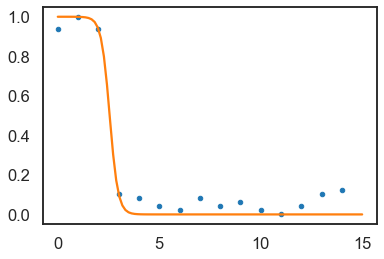

In [306]:
plt.plot(leftAverage, '.')
plt.plot(x,preds)

In [8]:
# Save results for inference-based
filename = 'EGreedyInferenceBasedAgent-prob0to1-062621.mat'
if not os.path.exists(filename):
    scipy.io.savemat(filename, {'pswitchlst': pswitchlst,
                    'prewlst': prewlst, 'N_iters': N_iters, 'num_states': num_states,
                    'obs_dim': obs_dim, 'rlow': rlow, 'rhigh': rhigh, 'eps': eps,
                    'ntrials_per_block': ntrials_per_block, 'T11lst': T11lst, 'T22lst': T22lst,
                    'E1lst': E1lst, 'E2lst': E2lst, 'efflist': efflist, 'PRslopelist': PRslopelist,
                    'PRoffsetlist': PRoffsetlist, 'PLslopelist': PLslopelist, 'PLoffsetlist': PLoffsetlist})
else:
    print('File exists! Skipping save...')

In [103]:
# Save results for q-learning
filename = 'EGreedyQLearning-prob0.2to0.8-062621b.mat'
if not os.path.exists(filename):
    scipy.io.savemat(filename, {'gammalst': gammalst,
                    'epslst': epslst, 'N_iters': N_iters, 'num_states': num_states,
                    'obs_dim': obs_dim, 'rlow': rlow, 'rhigh': rhigh, 'eps': eps,
                    'ntrials_per_block': ntrials_per_block, 'T11lst': T11lst, 'T22lst': T22lst,
                    'E1lst': E1lst, 'E2lst': E2lst, 'efflist': efflist, 'PRslopelist': PRslopelist,
                    'PRoffsetlist': PRoffsetlist, 'PLslopelist': PLslopelist, 'PLoffsetlist': PLoffsetlist,
                    'LapseL': LapseL, 'LapseR': LapseR})
else:
    print('File exists! Skipping save...')

Text(0.5, 1.0, 'Foraging efficiency')

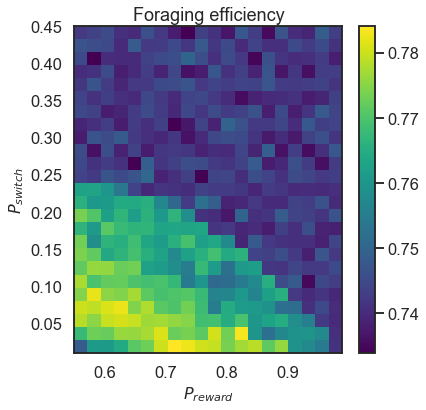

In [118]:
# Figure out some params for plotting depending on the simtype
if simtype == 'qlearning':
    xlst = epslst
    ylst = gammalst
    xlabel = 'epsilon'
    ylabel = 'gamma'
    
    
elif simtype == 'inf-based':
    xlst = prewlst
    ylst = pswitchlst
    xlabel = r'$P_{reward}$'
    ylabel = r'$P_{switch}$'

# Plot of foraging efficiency
plt.figure(figsize=(6, 6))
plt.imshow(efflist, origin='lower', cmap='viridis', aspect='auto', 
              extent=[min(xlst), max(xlst), min(ylst), max(ylst)])
plt.colorbar()

fontdict = {'fontsize': 16,
 'fontweight': 2}

plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Foraging efficiency')


Text(0.5, 1.0, 'Left lapse')

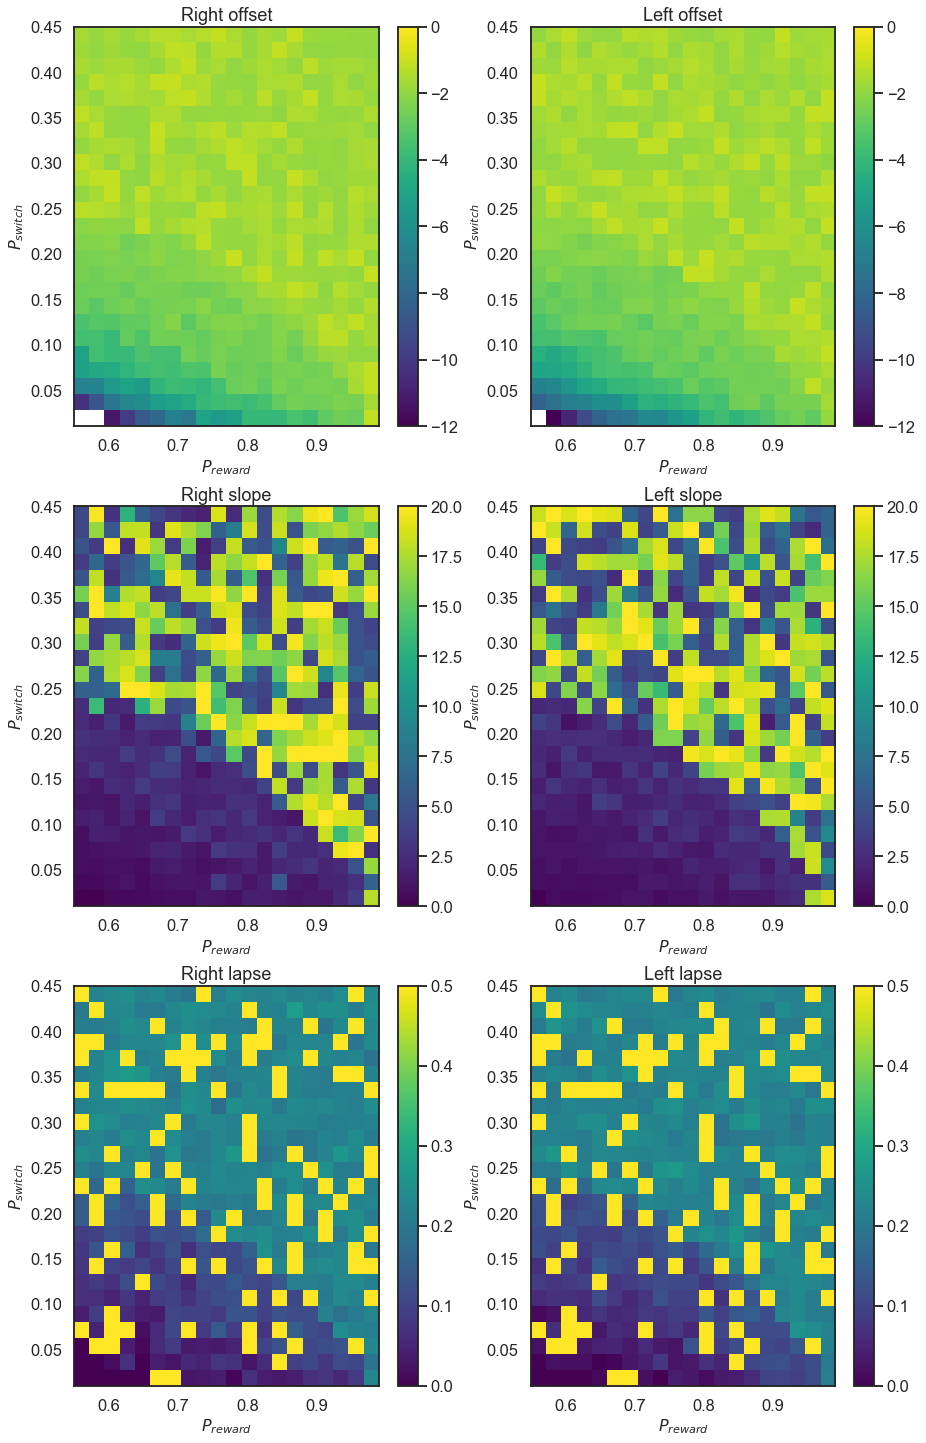

In [119]:
# Plot of foraging efficiency
plt.figure(figsize=(15, 25))
plt.subplot(321)
plt.imshow(PRoffsetlist, origin='lower', cmap='viridis', aspect='auto', 
              extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
          vmin=-12, vmax=0)
plt.colorbar()

fontdict = {'fontsize': 16,
 'fontweight': 2}

plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Right offset')


# Plot of transition probability
plt.subplot(322)
plt.imshow(PLoffsetlist, aspect='auto', origin='lower', cmap='viridis',
           extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
           vmin=-12, vmax=0
          )
plt.colorbar()
plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Left offset')

plt.subplot(323)
plt.imshow(PRslopelist, aspect='auto', origin='lower', cmap='viridis',
           extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
          vmin=0, vmax=20
        )
plt.colorbar()
plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Right slope')


plt.subplot(324)
plt.imshow(-PLslopelist, aspect='auto', origin='lower', cmap='viridis',
           extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
          vmin=0, vmax=20)
plt.colorbar()
plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Left slope')

plt.subplot(325)
plt.imshow(LapseR, origin='lower', cmap='viridis', aspect='auto', 
              extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
          vmin=0, vmax=0.5)
plt.colorbar()

fontdict = {'fontsize': 16,
 'fontweight': 2}

plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Right lapse')


# Plot of transition probability
plt.subplot(326)
plt.imshow(LapseL, aspect='auto', origin='lower', cmap='viridis',
           extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
           vmin=0, vmax=0.5
          )
plt.colorbar()
plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Left lapse')


In [54]:
world = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
agent = EGreedyQLearningAgent(gamma=1.1, eps=0.3)
exp = Experiment(agent, world)
exp.run()  


([True,
  0,
  False,
  True,
  0,
  True,
  0,
  0,
  False,
  0,
  0,
  0,
  False,
  True,
  0,
  0,
  0,
  0,
  0,
  True,
  0,
  0,
  0,
  False,
  0,
  1,
  False,
  False,
  1,
  1,
  1,
  False,
  1,
  1,
  False,
  False,
  1,
  1,
  True,
  1,
  1,
  True,
  False,
  0,
  0,
  0,
  0,
  True,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  False,
  0,
  1,
  1,
  False,
  1,
  1,
  1,
  1,
  1,
  False,
  1,
  False,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  False,
  0,
  0,
  True,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  True,
  0,
  0,
  1,
  1,
  1,
  1,
  True,
  1,
  1,
  1,
  1,
  1,
  True,
  1,
  False,
  1,
  1,
  1,
  1,
  True,
  1,
  1,
  1,
  0,
  True,
  False,
  0,
  0,
  True,
  0,
  True,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  True,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  True,
  False,
  1,
  1,
  True,
  1,
  1,
  False,
  False,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  False,
  False,
  0,
  True,
  0,
  0,
  0,
  0,
  False,
  True,
  True,
  False,
  0,
  0,
  0

[1.00000999999,
 1.00000999999,
 0.999999000001,
 1.0000000999999,
 0.99999999000001,
 1.000000000999999,
 0.9999999999000001,
 1.00000000001,
 0.999999999999,
 0.999999999999,
 1.0000000000001,
 -0.10000000000001008,
 -0.10000000000001008,
 -0.10000000000001008,
 -0.10000000000001008,
 -0.10000000000001008,
 -0.10000000000001008,
 -0.10000000000001008,
 -0.10000000000001008,
 -0.10000000000001008,
 -0.10000000000001008,
 -0.10000000000001008,
 -0.10000000000001008,
 -0.10000000000001008,
 0.010000000000001022,
 0.010000000000001022,
 0.010000000000001022,
 0.010000000000001022,
 0.010000000000001022,
 0.010000000000001022,
 0.010000000000001022,
 0.010000000000001022,
 0.010000000000001022,
 1.0990000000000002,
 1.0990000000000002,
 0.9901,
 1.00099,
 0.999901,
 0.999901,
 1.0000099,
 1.0000099,
 0.99999901,
 1.000000099,
 0.9999999901,
 1.00000000099,
 0.999999999901,
 1.0000000000099,
 0.99999999999901,
 0.99999999999901,
 1.000000000000099,
 -0.10000000000001008,
 -0.10000000000001

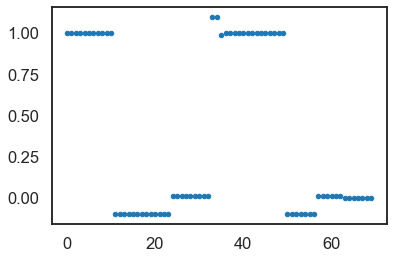

In [80]:
plt.plot(agent.q0_history[80:150], '.')
(agent.q0_history[80:150])

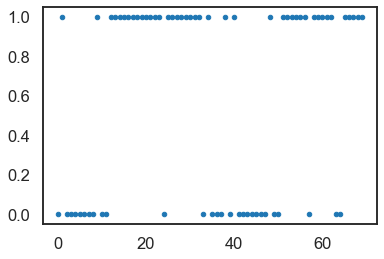

In [72]:
plt.plot(agent.choice_history[80:150], '.')

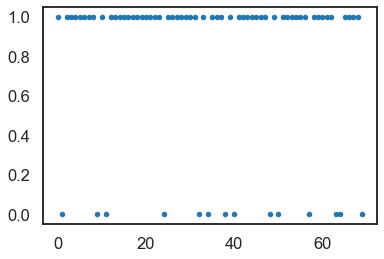

In [75]:
plt.plot(agent.outcome_history[80:150], '.')